# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Skillfactory---Практический-Machine-Learning" data-toc-modified-id="Skillfactory---Практический-Machine-Learning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Skillfactory - Практический Machine Learning</a></div><div class="lev2 toc-item"><a href="#19/02/2018---Аномалии,-работа-с-признаками,-пайплайны-(практика)" data-toc-modified-id="19/02/2018---Аномалии,-работа-с-признаками,-пайплайны-(практика)-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>19/02/2018 - Аномалии, работа с признаками, пайплайны (практика)</a></div><div class="lev1 toc-item"><a href="#Создание-пайплайна-и-генерация-признаков" data-toc-modified-id="Создание-пайплайна-и-генерация-признаков-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Создание пайплайна и генерация признаков</a></div><div class="lev2 toc-item"><a href="#Посмотрим-на-данные" data-toc-modified-id="Посмотрим-на-данные-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Посмотрим на данные</a></div><div class="lev2 toc-item"><a href="#Генерим-признаки" data-toc-modified-id="Генерим-признаки-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Генерим признаки</a></div><div class="lev2 toc-item"><a href="#Подбор-гипер-параметров" data-toc-modified-id="Подбор-гипер-параметров-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Подбор гипер-параметров</a></div><div class="lev3 toc-item"><a href="#Pipeline" data-toc-modified-id="Pipeline-231"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Pipeline</a></div><div class="lev3 toc-item"><a href="#Подбор-гиперпараметров" data-toc-modified-id="Подбор-гиперпараметров-232"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Подбор гиперпараметров</a></div><div class="lev4 toc-item"><a href="#Grid-search" data-toc-modified-id="Grid-search-2321"><span class="toc-item-num">2.3.2.1&nbsp;&nbsp;</span>Grid search</a></div><div class="lev4 toc-item"><a href="#Random-Search" data-toc-modified-id="Random-Search-2322"><span class="toc-item-num">2.3.2.2&nbsp;&nbsp;</span>Random Search</a></div><div class="lev3 toc-item"><a href="#HyperOpt" data-toc-modified-id="HyperOpt-233"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>HyperOpt</a></div><div class="lev2 toc-item"><a href="#Ваш-черед" data-toc-modified-id="Ваш-черед-24"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Ваш черед</a></div><div class="lev3 toc-item"><a href="#Новые-признаки" data-toc-modified-id="Новые-признаки-241"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Новые признаки</a></div><div class="lev2 toc-item"><a href="#Поиск-гиперпараметров" data-toc-modified-id="Поиск-гиперпараметров-25"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Поиск гиперпараметров</a></div>

# Skillfactory - Практический Machine Learning
## 19/02/2018 - Аномалии, работа с признаками, пайплайны (практика)

<center> Шестаков Андрей </center>

In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier


%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

# Создание пайплайна и генерация признаков
<center>Шестаков Андрей</center>

В этом задании мы рассмотрим данные с предыдущего Sberbank Data Science Contest. К сожалению найти страницу с конкурсом уже не получается.

Одной из задач была опредление пола владельца карты по его транзакциям на карте. Зачем это нужно - одному сберу известно, но эта задача была хороша тем, что в ней можно нагенерировать много разных признаков

Есть такая [презентация](https://alexanderdyakonov.files.wordpress.com/2016/10/dj2016_sdsj_vis.pdf) с предварительным анализом данных и идеями про признаки

Нам понадобятся файлы `customers_gender_train.csv`, `transactions.tsv.gz`, `mcc_types.tsv` и `trans_types.tsv`.

## Посмотрим на данные

Это метки ответов

In [2]:
df_gender = pd.read_csv('data/customers_gender_train.csv')
df_gender.head()

,customer_id,gender
0,75562265,0
1,10928546,1
2,69348468,1
3,84816985,1
4,61009479,0


Это сами транзакции (отрицательные транзакции - списывание, положительные - зачисление на счет)

In [3]:
df_transactions = pd.read_csv('data/transactions.csv')
df_transactions.head()

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN
1,39026145,1 10:19:29,6011,7010,56147.89,NaN
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN
4,39026145,2 15:33:42,5499,1010,-920.83,NaN


Далее, расшифровки кодов [mcc](https://ru.wikipedia.org/wiki/Merchant_Category_Code) и транзакций

In [4]:
df_tr = pd.read_csv('data/tr_types.csv', sep=';')
df_tr.head()

,tr_type,tr_description
0,3200,Плата за предоставление услуг посредством моби...
1,3210,Плата за предоставление отчета по счету карты ...
2,3800,Плата за обслуживание банковской карты (за пер...
3,4000,Плата за получение наличных в Сбербанке
4,4001,Плата за получение наличных в Сбербанке (в дру...


In [5]:
df_mcc = pd.read_csv('data/tr_mcc_codes.csv', sep=';')
df_mcc.head()

,mcc_code,mcc_description
0,742,Ветеринарные услуги
1,1711,"Генеральные подрядчики по вентиляции, теплосна..."
2,1731,Подрядчики по электричеству
3,1799,"Подрядчики, специализированная торговля — нигд..."
4,2741,Разнообразные издательства/печатное дело


Первое что мы видем - это странная дата и суммы в транзакциях. 

В принципе, посмотрев на исходное распределение "относительных" дат по какой-нибудь гендерной группы mcc, становится примерно понятно, что за даты закодированы.

Ну а суммы транзакций организаторы просто умножили на $\pi^{\exp}$ =)

Преобразование будет проделано ниже, но при желании, можете сами со всем разобраться.

In [6]:
from pandas import Timestamp, DateOffset

In [7]:
def preproc_transactions(df_transactions):
    sec_per_day = 86400
    sec_per_hour = 3600
    
    start_date = 1420070400 - 154 * sec_per_day - 3 * sec_per_hour
    
    df_transactions.loc[:, 'day'] = df_transactions.tr_datetime\
                                               .str.split(' ')\
                                               .str.get(0)\
                                               .astype(int)
    df_transactions.loc[:, 'time_raw'] = df_transactions.tr_datetime\
                                                    .str.split(' ')\
                                                    .str.get(1)

    # set temp dt
    df_transactions.loc[:, 'dt_temp'] = pd.to_datetime(df_transactions.loc[:, 'time_raw'], 
                                                    format='%H:%M:%S')\
                                        + DateOffset(years=115)
    
    df_transactions = df_transactions.assign(dt = lambda x: x.dt_temp.astype(np.int64) // 10**9
                                             + (x.day - 153) * sec_per_day)\
                                     .assign(weekday = lambda x: ((x.day + 4) % 7 + 1))
        
    df_transactions.loc[:, 'datetime'] = pd.to_datetime(df_transactions.dt, unit='s')
    df_transactions.loc[:, 'date'] = df_transactions.loc[:, 'datetime'].dt.strftime('%Y-%m-%d')
    df_transactions.loc[:, 'hour'] = df_transactions.loc[:, 'datetime'].dt.strftime('%H')
    
    df_transactions = df_transactions.drop(['dt_temp', 'time_raw', 'tr_datetime'], axis=1)
    
    df_transactions.loc[:, 'amount'] = np.round(df_transactions.loc[:, 'amount']/(np.pi**np.exp(1)))
            
    return df_transactions

In [8]:
df_transactions = df_transactions.pipe(preproc_transactions)

In [9]:
df_transactions.head()

,customer_id,mcc_code,tr_type,amount,term_id,day,dt,weekday,datetime,date,hour
0,39026145,4814,1030,-100.0,NaN,0,1406888606,5,2014-08-01 10:23:26,2014-08-01,10
1,39026145,6011,7010,2500.0,NaN,1,1406974769,6,2014-08-02 10:19:29,2014-08-02,10
2,39026145,4829,2330,-2500.0,NaN,1,1406974856,6,2014-08-02 10:20:56,2014-08-02,10
3,39026145,5499,1010,-62.0,NaN,1,1406975994,6,2014-08-02 10:39:54,2014-08-02,10
4,39026145,5499,1010,-41.0,NaN,2,1407080022,7,2014-08-03 15:33:42,2014-08-03,15


## Генерим признаки

В качестве базовых признаков, можно взять, например, 
* количество (доля) транзакций по каждому mcc_code
* количество (доля) транзакций в разные промежутки времени

In [22]:
def gen_features(df_gender, df_transactions):
    
    df_mcc_counts = df_transactions.pivot_table(index=['customer_id'], columns='mcc_code', values='amount', 
                             aggfunc=np.size, fill_value=0)

    df_mcc_counts = df_mcc_counts.rename_axis(lambda x: 'mcc_{}_count'.format(x), axis=1)

    df_hour_rations = df_transactions.pivot_table(index=['customer_id'], columns='hour', values='amount', 
                             aggfunc=np.size, fill_value=0)

    # Сложная и нетривиальная конструкция
    total = df_hour_rations.sum(axis=1)
    df_hour_rations.loc[:, 'morning'] = (df_hour_rations.loc[:, '05':'11'].sum(axis=1).T/total).T
    df_hour_rations.loc[:, 'day'] = (df_hour_rations.loc[:, '12':'17'].sum(axis=1).T/total).T
    df_hour_rations.loc[:, 'evening'] = (df_hour_rations.loc[:, '18':'23'].sum(axis=1).T/total).T
    df_hour_rations.loc[:, 'night'] = (df_hour_rations.loc[:, '00':'04'].sum(axis=1).T/total).T


    # Объединяем:
    df_features = df_gender.join(df_mcc_counts, on='customer_id', how='left')\
                           .join(df_hour_rations.loc[:, ['morning', 'day', 'evening', 'night']], on='customer_id', how='left')
        
    return df_features

In [23]:
df_features = df_gender.pipe(gen_features, df_transactions)

C:\Users\temirlan.smail\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  


In [24]:
label = 'gender'
idx_features = df_features.columns != label

In [25]:
X = df_features.loc[:, idx_features].values
y = df_features.loc[:, ~idx_features].values.flatten()

## Подбор гипер-параметров

### Pipeline

Сделаем простой sklearn пайплайн, который делает следующее:
* Нормирует признаки через StandartScaler
* Запускает лог-регрессию

In [29]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression

In [30]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression())
])

In [31]:
RND_SEED = 123

### Подбор гиперпараметров

До этого мы исключительно смотрели, как влияет на меру качества какой-то один параметр при фиксированных остальных. Пришло время перебирать все что можно!

В базовом варианте, это делается либо через `Grid Search`, либо через `Random Search`. Какие ключевые отличия?
* В `Grid Search` вы в явнов виде задаете возможные значения каждого гипер-параметра, который хотите варьировать. Соответственно, выполняется **полный** перебор всех возможных комбинаций
* В `Random Search` допукается указание распределения параметров, например "равномерно, на интервале от 0 до 100" или "нормальное распределение с таким-то цетром и такой-то дисперсией. Соответственно, так как это случайный перебор, то **вы** просто **задаете** количество случайных комбинаций, которые будут проверяться

Может показаться, что делать случайный перебор опасно - там же все случайно. Но на практике именно он и искользуется в силу двух причин
* Полный перебор большого количества комбинаций очень долгий
* Мы можем просто пропустить значения гиперпараметра, которые сильно влияют на метрику качества (см рисунок снизу)

<img src='img/gridsearch.jpeg'>

Попробуем оба варианта

#### Grid search

In [33]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

In [34]:
# Задаем значения параметров, которые хотим проверить

# в данном случае "__" разленяет название гиперпараметра от этапа, где этот гиперпараметр используется
# если у нас будет не пайплайн, а просто один классификатор, то разделитель указывать не нужно
param_grid = {
    'scaler__with_mean': [False, True],
    'clf__penalty': ['l1', 'l2'],
    'clf__random_state': [RND_SEED],
    'clf__C': np.logspace(-5, 3, 10)
}

print(param_grid)

# Задаем схему кросс-валидации
cv = StratifiedKFold(n_splits=5, random_state=RND_SEED, shuffle=True)

{'scaler__with_mean': [False, True], 'clf__penalty': ['l1', 'l2'], 'clf__random_state': [123], 'clf__C': array([1.00000000e-05, 7.74263683e-05, 5.99484250e-04, 4.64158883e-03,
       3.59381366e-02, 2.78255940e-01, 2.15443469e+00, 1.66810054e+01,
       1.29154967e+02, 1.00000000e+03])}


In [35]:
grid_searcher = GridSearchCV(model, param_grid, 
                             scoring='roc_auc', 
                             n_jobs=-1, cv=cv, 
                             verbose=2)

grid_searcher.fit(X, y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'scaler__with_mean': [False, True], 'clf__penalty': ['l1', 'l2'], 'clf__random_state': [123], 'clf__C': array([1.00000e-05, 7.74264e-05, 5.99484e-04, 4.64159e-03, 3.59381e-02,
       2.78256e-01, 2.15443e+00, 1.66810e+01, 1.29155e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

На выходе в grid_searcher можно посмотреть, какая комбинация оказалась наилучшей, сколько занял рачет и напрямую достать лучшую модель.

In [36]:
grid_searcher.best_params_

{'clf__C': 0.03593813663804626,
 'clf__penalty': 'l1',
 'clf__random_state': 123,
 'scaler__with_mean': True}

In [37]:
grid_searcher.best_score_

0.8333672337310287

In [38]:
results = pd.DataFrame(grid_searcher.cv_results_)

C:\Users\temirlan.smail\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\temirlan.smail\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\temirlan.smail\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

In [39]:
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__penalty,param_clf__random_state,param_scaler__with_mean,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.256480,0.088011,0.016044,0.007845,1e-05,l1,123,False,"{'clf__C': 1e-05, 'clf__penalty': 'l1', 'clf__...",0.500000,...,0.500000,0.000000,36,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000
1,0.357951,0.035516,0.021859,0.001169,1e-05,l1,123,True,"{'clf__C': 1e-05, 'clf__penalty': 'l1', 'clf__...",0.500000,...,0.500000,0.000000,36,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000
2,0.323460,0.005549,0.021860,0.004967,1e-05,l2,123,False,"{'clf__C': 1e-05, 'clf__penalty': 'l2', 'clf__...",0.785334,...,0.793321,0.006108,34,0.797821,0.800335,0.800359,0.796988,0.800062,0.799113,0.001423
3,0.555878,0.019644,0.030482,0.009202,1e-05,l2,123,True,"{'clf__C': 1e-05, 'clf__penalty': 'l2', 'clf__...",0.786911,...,0.797828,0.010103,33,0.799328,0.810066,0.808778,0.799038,0.803717,0.804185,0.004604
4,0.333889,0.015310,0.022661,0.003621,7.74264e-05,l1,123,False,"{'clf__C': 7.742636826811278e-05, 'clf__penalt...",0.500000,...,0.500000,0.000000,36,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000


In [40]:
best_model = grid_searcher.best_estimator_

#### Random Search

In [41]:
from scipy.stats import randint as sp_randint
from scipy.stats import lognorm as sp_lognorm

In [42]:
sp_lognorm(4).rvs()

0.019189768258024608

In [43]:
# Задаем значения параметров, которые хотим проверить
# Теперь с распределениями
param_grid = {
    'scaler__with_mean': [False, True],
    'clf__penalty': ['l1', 'l2'],
    'clf__random_state': [RND_SEED],
    'clf__C': sp_lognorm(4)
}

print(param_grid)

{'scaler__with_mean': [False, True], 'clf__penalty': ['l1', 'l2'], 'clf__random_state': [123], 'clf__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001DA33358DA0>}


In [44]:
# Рассмотрим 20 случайных комбинаций
random_searcher = RandomizedSearchCV(model, param_grid, n_iter=20, 
                                     random_state=RND_SEED,
                                     scoring='roc_auc', 
                                     n_jobs=-1, cv=cv, 
                                     verbose=2)

random_searcher.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.9s finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
          error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'scaler__with_mean': [False, True], 'clf__penalty': ['l1', 'l2'], 'clf__random_state': [123], 'clf__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001DA33358DA0>},
          pre_dispatch='2*n_jobs', random_state=123, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=2)

Аналогичный выхлоп

In [45]:
random_searcher.best_params_

{'clf__C': 0.066168907176401,
 'clf__penalty': 'l1',
 'clf__random_state': 123,
 'scaler__with_mean': False}

In [46]:
random_searcher.best_score_

0.8331585112406745

In [47]:
results = pd.DataFrame(random_searcher.cv_results_)

C:\Users\temirlan.smail\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\temirlan.smail\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\temirlan.smail\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

In [48]:
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__penalty,param_clf__random_state,param_scaler__with_mean,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.267512,0.091270,0.012634,0.003391,0.0130037,l1,123,False,"{'clf__C': 0.013003686130638284, 'clf__penalty...",0.827471,...,0.829823,0.004285,10,0.835124,0.834699,0.835106,0.835920,0.833295,0.834829,0.000863
1,0.744379,0.069238,0.020856,0.001726,54.0215,l1,123,True,"{'clf__C': 54.02148221946703, 'clf__penalty': ...",0.829487,...,0.829797,0.003313,14,0.849481,0.850480,0.849283,0.850175,0.848428,0.849569,0.000719
2,2.909741,0.157913,0.016044,0.000897,0.0988254,l1,123,True,"{'clf__C': 0.09882536189042468, 'clf__penalty'...",0.831300,...,0.832554,0.003362,3,0.848457,0.849135,0.847939,0.849446,0.847167,0.848429,0.000820
3,0.754806,0.067489,0.022258,0.004274,739.331,l1,123,True,"{'clf__C': 739.3313143249965, 'clf__penalty': ...",0.829473,...,0.829788,0.003311,16,0.849479,0.850481,0.849282,0.850174,0.848428,0.849569,0.000720
4,0.260693,0.005229,0.021257,0.007269,6.08732e-05,l1,123,False,"{'clf__C': 6.0873234832561394e-05, 'clf__penal...",0.500000,...,0.500000,0.000000,19,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000


In [49]:
best_model = random_searcher.best_estimator_

### HyperOpt

Есть еще другой вариант - "умный" перебор параметров. И вот тут нам помогает библиотека `hyperopt`.

Если невдаваться в детали, то `hyperopt` определяет следующего набора-кандидата с помощью некоторого алгоритма, который балансирует исследование еще не изведанных областей значений гиперпараметров и направления, вдоль которых наблюдались улучшения целеой метрики.

То есть мы задаем некоторую функцию, и ставим себе цель **минимизировать** (такова договоренность в `hyperopt`) ее значение исходя из параметров, которые она принимает.

Например, возьмем функцию $f(x) = \sin(x)/x$ и будем искать ее минимум при условии, что $x$ будет равномерно распределен на интервале $[-7.5, 7.5]$

In [ ]:
# sudo pip install networkx==1.11

In [50]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, rand

In [52]:
trials = Trials()
best = fmin(
    fn=lambda x: -np.sin(x)/x,
    space=hp.uniform('x', -7.5, 7.5),
    algo=tpe.suggest,
    max_evals=100,
    trials=trials)

print(best)

{'x': 0.010897335967094957}


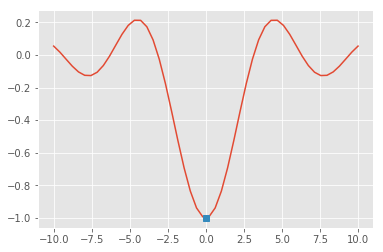

In [53]:
x = np.linspace(-10,10,50)
func = lambda x: -np.sin(x)/x
y = func(x)
plt.plot(x,y)

y_best = func(best['x'])
plt.plot(best['x'], y_best, marker='s')

Нашли)

Возвращаясь к нашим баранам, функция вданном случае будет возвращать метрику качества модели (пайплайна) на кроссвалидации. С помощью `hyperopt` мы будем искать минимум этой функции при заданных диаполознах значений гипер параметров.

Но самым важным плюсом, как по мне, является гибкость - в функцию, которую мы хотим минимизировать можно написать все что угодно. Например, сейчас я добавлю вариативность в пайплайне по типу шкалирования между - StandartScaler или RobustScaler.

In [54]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score

In [55]:
X = df_features.loc[:, idx_features].values
y = df_features.loc[:, ~idx_features].values.flatten()

In [61]:
def run_trials_template(X, y, params, evals=100):

    def hyperopt_cv(X, y, params):
        
        X_ = X.copy()
        
        # Отделяем параметры лог регрессии в отдельный словарь
        lm_params = {}
        for k, v in params.items():
            if k.startswith('glob'):
                continue                
            elif k.startswith('lm'):
                lm_params[k.split('_', 1)[1]] = v
    
    
        # Задаем шкалирование
        if params['scaler_type'] == 'standart':
            scaler = StandardScaler(with_mean=params['scaler_centering'])
        else:
            assert params['scaler_type'] == 'robust'
            scaler = RobustScaler(with_centering=params['scaler_centering'])
        
        # Создаем лог рег с нужными параметрами
        clf = LogisticRegression(**lm_params)
        
        # Итоговый пайплайн
        model = Pipeline([
            ('scaler', scaler),
            ('clf', clf)
        ])

        # Схема кросс-валидации
        n_splits = 5
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, 
                             random_state=RND_SEED)
        scores = cross_val_score(model, X_, y,
                                 scoring='roc_auc', 
                                 cv=cv, 
                                 n_jobs=-1)

        # Возвращаем среднее значение метрики и отклонение (на всякий случай)
        return scores.mean(), scores.std()

    def f(params):
        acc, std = hyperopt_cv(X, y, params)
        return {'loss': -acc, 'qscore': -acc, 'qscore_std': std, 'status': STATUS_OK}

    trials = Trials()
    best = fmin(f, 
                params, 
                algo=tpe.suggest, 
                max_evals=evals, 
                trials=trials, 
                verbose=1)
    
    return trials

In [57]:
# Задаем пространство поиска
space4_lm = {
    'lm_penalty': hp.choice('penalty', ['l1', 'l2']),
    'lm_C': hp.loguniform('C', -5, 3),
    'lm_class_weight': hp.choice('class_weight', [None, 'balanced']),
    'lm_random_state': RND_SEED,
    'scaler_type': hp.choice('scaler_type', ['standart', 'robust']),
    'scaler_centering': hp.choice('scaler_centering', [False, True])
}

In [62]:
# Запускаем поиск
trials = run_trials_template(X, y, space4_lm, evals=40)

In [65]:
def trials_df(trials):
    '''
    Функция форматирует результаты hyperopt в dataframe
    '''
    tr_dict = []
    for t in trials:
        trial = dict()
        for k, v in t['misc']['vals'].items():
            trial[k] = v[0]

        trial['qscore'] = -t['result']['qscore']
        trial['qscore_std'] = -t['result']['qscore_std']
        tr_dict.append(trial)

    df_res = pd.DataFrame.from_dict(tr_dict)
    df_res = df_res.sort_values('qscore', ascending=False)
    
    return df_res

Достаем результаты.

Стоит оговорится, что в некоторых столбцах указаны не фактические значение гиперпараметров, а их позиция в соответствуюем поле в `space4_lm`

In [66]:
df_trials = trials_df(trials)

Здесь `qscore` - метрика качесва, а `scaler_type = 1` означает, что был выбран `scaler_type = robust`

In [67]:
df_trials.head()

,C,class_weight,penalty,qscore,qscore_std,scaler_centering,scaler_type
33,0.026375,0,0,0.836940,-0.003530,0,1
23,0.024829,0,0,0.836938,-0.003601,0,1
26,0.030312,0,0,0.836874,-0.003423,0,1
25,0.020211,0,0,0.836822,-0.003894,0,1
22,0.017641,0,0,0.836661,-0.003991,0,1


## Ваш черед

### Новые признаки

Задание творческое - придумайте по новому признаку (группе признаков)
* На основе mcc (tr_type)
* На основе временного фактора
* На основе текстов из описания mcc

Реалиуйте их в функции, аналогичной `gen_features`.

    Генерирование фичей:

1. Старые фичи: кол-во транз по каждому mcc, доля транзакций от времени суток


2. Новые фичи: кол-во транз по каждому tr_type; кол-во транз по каждому дню недели; кол-во транз 7,8 марта; кол-во транз 22, 23 февраля; кол-во транз 13, 14 февраля; среднее, стандарт отклонение, медиана, максимум, сумма по сумме поступления; среднее, стандарт отклонение, медиана, максимум, сумма по сумме снятия; кол-во ATM транзакций; кол-во POS транзакций.

In [208]:
# 14 feb (+ 13 feb) - year.02.13 or year.02.14
# 23 feb (+ 22 feb) - year.02.22 or year.02.23
# 8 mar (+ 7 mar) - year.03.07 or year.03.08
def holiday_func(d):
    if d.split('-')[1] == '02':
        if d.split('-')[2] == '13' or d.split('-')[2] == '14':
            return '14_feb'
        if d.split('-')[2] == '22' or d.split('-')[2] == '23':
            return '23_feb'
    elif d.split('-')[1] == '03':
        if d.split('-')[2] == '07' or d.split('-')[2] == '08':
            return '8_mar'
    else:
        return 'not_holiday'

# sum < 0 - out, sum >= 0 - in
def out_in_fun(s):
    if s < 0:
        return 'out'
    else:
        return 'in'
    
# ATM or POS
def atm_pos(s):
    if type(s) == str:
        if 'ATM' in s or 'АТМ' in s:
            return 'ATM'
        elif 'POS' in s:
            return 'POS'
        else:
            return 'none'
    else:
        return 'none'

In [222]:
def gen_features_new(df_gender, df_transactions, df_tr, df_mcc):
    # старые фичи
    
    df_mcc_counts = df_transactions.pivot_table(index=['customer_id'], columns='mcc_code', values='amount', 
                             aggfunc=np.size, fill_value=0)

    df_mcc_counts = df_mcc_counts.rename_axis(lambda x: 'mcc_{}_count'.format(x), axis=1)

    df_hour_rations = df_transactions.pivot_table(index=['customer_id'], columns='hour', values='amount', 
                             aggfunc=np.size, fill_value=0)

    # Сложная и нетривиальная конструкция
    total = df_hour_rations.sum(axis=1)
    df_hour_rations.loc[:, 'morning'] = (df_hour_rations.loc[:, '05':'11'].sum(axis=1).T/total).T
    df_hour_rations.loc[:, 'day'] = (df_hour_rations.loc[:, '12':'17'].sum(axis=1).T/total).T
    df_hour_rations.loc[:, 'evening'] = (df_hour_rations.loc[:, '18':'23'].sum(axis=1).T/total).T
    df_hour_rations.loc[:, 'night'] = (df_hour_rations.loc[:, '00':'04'].sum(axis=1).T/total).T
    
    # новые фичи
    
    # кол-во транзакций по каждому tr_type
    df_tr_type_counts = df_transactions.pivot_table(index=['customer_id'], columns='tr_type', values='amount', 
                             aggfunc=np.size, fill_value=0)

    df_tr_type_counts = df_mcc_counts.rename_axis(lambda x: 'tr_type_{}_count'.format(x), axis=1)
    
    # кол-во транз по каждому дню недели
    df_weekday_counts = df_transactions.pivot_table(index=['customer_id'], columns='weekday', values = 'amount', 
                             aggfunc=np.size, fill_value=0)
    
    # кол-во транзакций 13 февраля, 14 февраля, 22 февраля, 23 февраля, 7 марта, 8 марта
    df_transactions['holiday'] = df_transactions['date'].apply(holiday_func)
    df_holiday_counts = df_transactions.pivot_table(index=['customer_id'], columns='holiday', values = 'amount', 
                             aggfunc=np.size, fill_value=0)
    df_holiday_counts.drop(['not_holiday'], axis = 1, inplace = True)
    
    # среднее, стандарт отклонение, медиана, сумма по сумме поступления
    # среднее, стандарт отклонение, медиана, сумма по сумме снятия
    df_transactions['out_in'] = df_transactions['amount'].apply(out_in_fun)
    df_amount_char = df_transactions.pivot_table(index=['customer_id'], columns='out_in', values = 'amount', 
                             aggfunc = [np.mean, np.std, np.median, sum], fill_value=0)
    
    # кол-во ATM транзакций и кол-во POS транзакций
    buf = pd.merge(df_transactions, df_tr, on='tr_type', how='left')
    buf['ATM_POS'] = buf['tr_description'].apply(atm_pos)
    df_atm_pos_counts = buf.pivot_table(index=['customer_id'], columns='ATM_POS', values='amount', 
                             aggfunc=np.size, fill_value=0)
    df_atm_pos_counts.drop(['none'], axis = 1, inplace = True)
    
    # все объединяем
    df_features = df_gender.merge(df_mcc_counts, on='customer_id', how='left')\
                    .merge(df_hour_rations.loc[:, ['morning', 'day', 'evening', 'night']], on='customer_id', how='left')\
                    .merge(df_tr_type_counts, on = 'customer_id', how='left')\
                    .merge(df_weekday_counts, on = 'customer_id', how ='left')\
                    .merge(df_holiday_counts, on = 'customer_id', how ='left')\
                    .merge(df_amount_char, on = 'customer_id', how ='left')\
                    .merge(df_atm_pos_counts, on = 'customer_id', how ='left')
    
    return df_features

In [223]:
df_features_new = gen_features_new(df_gender, df_transactions, df_tr, df_mcc)

C:\Users\temirlan.smail\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  import sys
C:\Users\temirlan.smail\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
C:\Users\temirlan.smail\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [224]:
df_features_new.head()

,customer_id,gender,mcc_742_count,mcc_1711_count,mcc_1731_count,mcc_1799_count,mcc_2741_count,mcc_3000_count,mcc_3351_count,mcc_3501_count,...,"(mean, in)","(mean, out)","(std, in)","(std, out)","(median, in)","(median, out)","(sum, in)","(sum, out)",ATM,POS
0,75562265,0,0,0,0,0,0,0,0,0,...,25160.680851,-5030.724907,29080.319153,10979.156718,18004.0,-50.0,1182552,-1353265,81,20
1,10928546,1,0,0,0,0,0,0,0,0,...,89281.904762,-47321.898860,97272.732157,60101.215395,50000.0,-20000.0,1874920,-33219973,410,208
2,69348468,1,0,0,0,0,0,0,0,0,...,886.000000,-600.900693,750.986019,685.682808,700.0,-300.0,4430,-260190,98,303
3,84816985,1,0,0,0,0,0,0,0,0,...,1059.565217,-248.851351,833.472900,458.003071,1000.0,-100.0,24370,-18415,34,37
4,61009479,0,0,0,0,0,0,0,0,0,...,2270.019417,-675.328804,3936.312450,2157.787691,1000.0,-183.0,233812,-248521,187,82


In [254]:
label = 'gender'
idx_features = df_features_new.columns != label

df_features_new.fillna(value = 0, axis = 1, inplace = True)

X_new = df_features_new.loc[:, idx_features].values
y_new = df_features_new.loc[:, ~idx_features].values.flatten()

## Поиск гиперпараметров

Реализуйте функцию для hyperopt по перебору гипер параметров вашего пайплайна

На всякий случай почитайте еще про [`FeatureUnion`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html) и [пример](http://scikit-learn.org/stable/auto_examples/hetero_feature_union.html#sphx-glr-auto-examples-hetero-feature-union-py)

In [ ]:
# А это трансформер, который выбирает подможнество столбцов из матрицы X
# Который нужен для того, чтобы делать какие-то действия только для подмноества столбцов, а потом объединять результаты
# Через FeatureUnion

from sklearn.base import BaseEstimator, TransformerMixin

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, col_idx):
        self.col_idx = col_idx
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[:, self.col_idx]

In [255]:
# Запускаем поиск
trials_new = run_trials_template(X_new, y_new, space4_lm, evals=40)

In [258]:
trials_new.best_trial['result']

{'loss': -0.8453899709650322,
 'qscore': -0.8453899709650322,
 'qscore_std': 0.003269966443078546,
 'status': 'ok'}

In [259]:
trials.best_trial['result']

{'loss': -0.8369403068252351,
 'qscore': -0.8369403068252351,
 'qscore_std': 0.003529800924389707,
 'status': 'ok'}

Качество немного улучшилось